For some reason, we're not seeing the improvement in constraining power as we go to larger volumes. Here we investigate the data vectors to see what could be going wrong.

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os
from os.path import join
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
mpl.style.use('./style.mcstyle')   # noqa
import numpy as np
import torch
import seaborn as sns
import pandas as pd
import warnings
from tqdm import tqdm
import h5py

# Suppress warnings
warnings.filterwarnings('ignore')

In [2]:

# # galaxies
# modeldir = '/anvil/scratch/x-mho1/cmass-ili/abacuslike/fastpm_hodzbias/models/galaxy/nbar+zPk0+zPk2+zPk4/kmin-0.0_kmax-0.4'
# diagfile = '/anvil/scratch/x-mho1/cmass-ili/abacuslike/fastpm_hodzbias/L2000-N256/663/diag/galaxies/hod06631.h5'
# # sgc_lightcone
# modeldir = '/anvil/scratch/x-mho1/cmass-ili/abacuslike/fastpm_recnoise/models/sgc_lightcone/nbar+nz+Pk0+Pk2+Pk4/kmin-0.0_kmax-0.4'
# diagfile = '/anvil/scratch/x-mho1/cmass-ili/abacuslike/fastpm_recnoise/L2000-N256/663/diag/sgc_lightcone/hod00001_aug00001.h5'
# # 1hod mtng_lightcone
# modeldir = '/anvil/scratch/x-mho1/cmass-ili/abacuslike/fastpm_recnoise_1hod/models/mtng_lightcone/nbar+nz+Pk0+Pk2+Pk4/kmin-0.0_kmax-0.4'
# diagfile = '/anvil/scratch/x-mho1/cmass-ili/abacuslike/fastpm_recnoise_1hod/L2000-N256/663/diag/mtng_lightcone/hod00001_aug00001.h5'
# 1hod mtng_lightcone
modeldir = '/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm_recnoise_rot/models/mtng_lightcone/nbar+nz+Pk0+Pk2+Pk4/kmin-0.0_kmax-0.4'
diagfile = '/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm_recnoise_rot/L2000-N256/663/diag/mtng_lightcone/hod00001_aug00001.h5'

xtrain = np.load(join(modeldir, 'x_train.npy'))
thetatrain = np.load(join(modeldir, 'theta_train.npy'))
xtest = np.load(join(modeldir, 'x_test.npy'))
thetatest = np.load(join(modeldir, 'theta_test.npy'))

print(xtest.shape)

thetarange = np.stack((thetatest.min(axis=0), thetatest.max(axis=0))).T
thetafid = np.mean(thetatest, axis=0)
thetafid

cosmonames = [r'$\Omega_m$', r'$\Omega_b$', r'$h$', r'$n_s$', r'$\sigma_8$']

(2860, 426)


In [4]:
with h5py.File(diagfile, 'r') as f:
    if 'Pk_k3D' not in f:
        a = list(f.keys())[0]
        f = f[a]
    k3D = f['Pk_k3D'][:]

kmin, kmax = 0.0, 0.4
k3D = k3D[(k3D >= kmin) & (k3D <= kmax)]
xk3D = np.concatenate([k3D]*3)

# to match new kmin/kmax indexing
kmin, kmax = 0.0, 0.4
mask = (xk3D >= kmin) & (xk3D <= kmax)
xk3D = xk3D[mask]
mask = np.concatenate([mask, np.ones(xtest.shape[-1] - len(mask), dtype=bool)])
xtest = xtest[:, mask]
xtrain = xtrain[:, mask]
Nk = len(xk3D)//3

template = xtest.mean(axis=0)
template_std = xtest.std(axis=0)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm_recnoise_rot/L2000-N256/663/diag/mtng_lightcone/hod00001_aug00001.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes


# def process_diagfile(diagfile):
#     with h5py.File(diagfile, 'r') as f:
#         if 'Pk_k3D' not in f:
#             closest_a = min(list(f.keys()), key=lambda x: abs(float(x) - 0.666))
#             f = f[closest_a]
#         k3D = f['Pk_k3D'][:]
#         Pk0 = f['Pk'][:, 0] - 1 / f.attrs['nbar']
#     kmin, kmax = 0.0, 0.4
#     mask = (k3D >= kmin) & (k3D <= kmax)
#     return k3D[mask], Pk0[mask]


# zoom_region = [[0.02, 0.2], [1e5, 1e7]]

# lhid = 663
# f, ax = plt.subplots(1, 1, figsize=(10, 6))
# zax = inset_axes(ax, width="40%", height="40%", loc="upper right")

# diagfile = '/anvil/scratch/x-mho1/cmass-ili/abacuslike/fastpm_hodzbias/L2000-N256/'
# diagfile += f'{lhid}/diag/galaxies/hod{lhid:04}1.h5'
# k3D, Pk0 = process_diagfile(diagfile)
# Pk0 *= 1e1
# ax.semilogy(k3D, Pk0, label='Galaxy Cube')
# zax.semilogy(k3D, Pk0, label='Galaxy Cube', lw=1)

# diagfile = '/anvil/scratch/x-mho1/cmass-ili/abacuslike/fastpm_recnoise/L2000-N256/'
# diagfile += f'{lhid}/diag/sgc_lightcone/hod00001_aug00001.h5'
# k3D, Pk0 = process_diagfile(diagfile)
# ax.semilogy(k3D, Pk0, label='SGC Lightcone')
# zax.semilogy(k3D, Pk0, label='SGC Lightcone', lw=1)

# diagfile = '/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm_recnoise/L3000-N384/'
# diagfile += f'{lhid}/diag/ngc_lightcone/hod00001_aug00001.h5'
# k3D, Pk0 = process_diagfile(diagfile)
# ax.semilogy(k3D, Pk0, label='NGC Lightcone')
# zax.semilogy(k3D, Pk0, label='NGC Lightcone', lw=1)

# ax.set(xlabel=r'$k\ [h/\mathrm{Mpc}]$',
#        ylabel=r'Re-normalized $P_0(k) - 1/\bar{n}$')
# ax.legend(loc='upper left')
# ax.plot([zoom_region[0][0], zoom_region[0][1], zoom_region[0][1], zoom_region[0][0], zoom_region[0][0]],
#         [zoom_region[1][0], zoom_region[1][0], zoom_region[1]
#             [1], zoom_region[1][1], zoom_region[1][0]],
#         color='k', linestyle='--', linewidth=1)
# ax.set_title(f'lhid={lhid}')

# # Customize the inset axis
# zax.set_xlim(zoom_region[0])
# zax.set_ylim(zoom_region[1])
# zax.set_xlabel(r'$k\ [h/\mathrm{Mpc}]$')

NameError: name 'template' is not defined

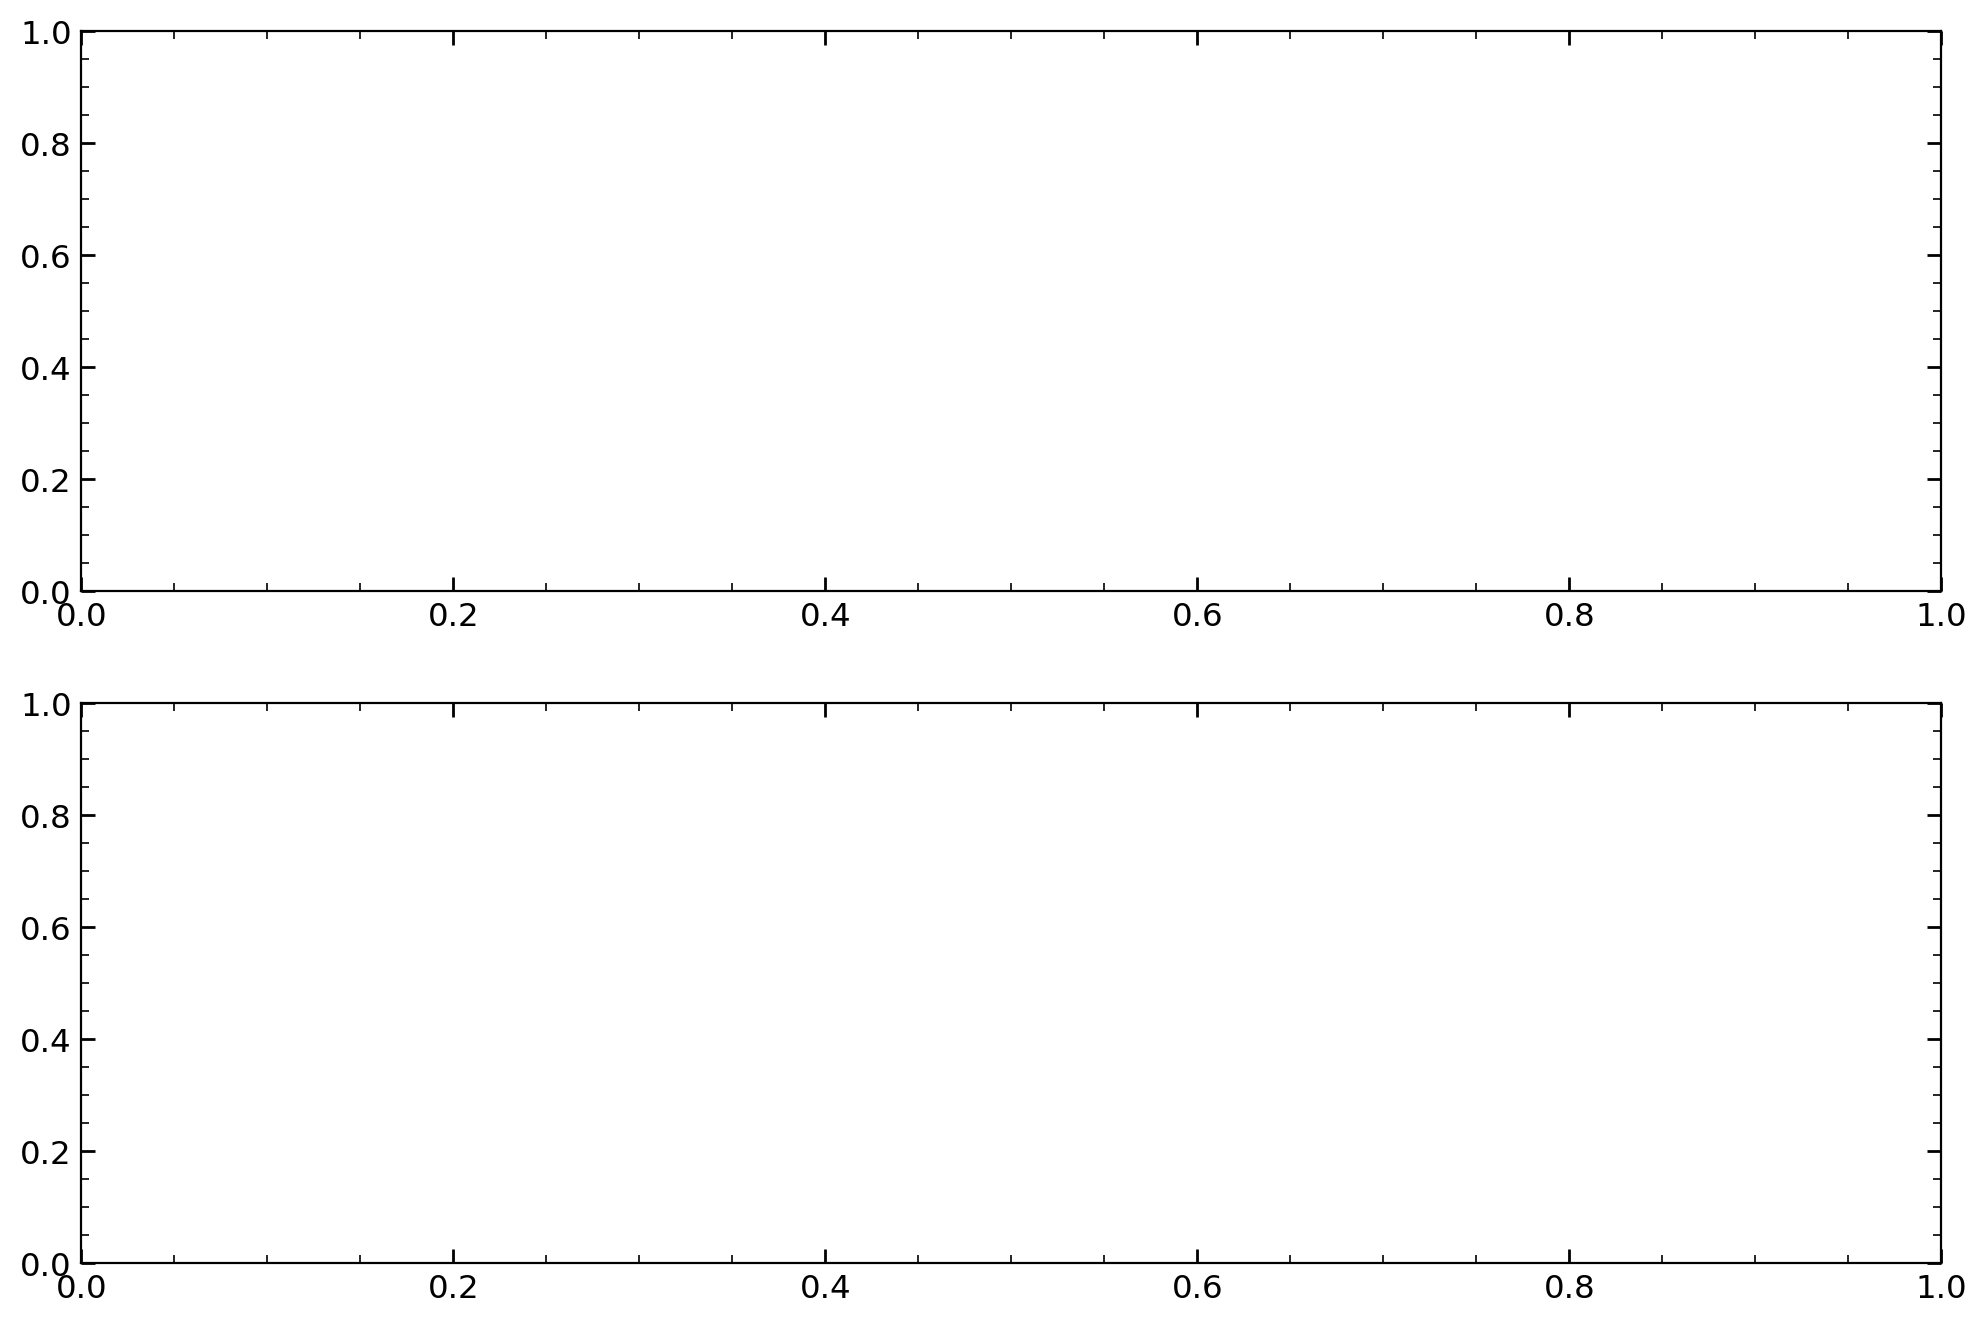

In [5]:
N = 200
Nbins = 3
f, axs = plt.subplots(2, 1, figsize=(12, 8), sharey=True)

ax = axs[0]


name = cosmonames[0]
k, l = 0, 4
norm = mpl.colors.Normalize(*thetarange[k])
selection = np.random.choice(np.argwhere(
    np.abs(thetatest[:, l] - thetafid[l]) < 0.1).flatten(), size=N, replace=False)
tbins = np.linspace(*thetarange[k], Nbins+1)
for i in range(len(tbins) - 1):
    mask = (thetatest[selection, k] >= tbins[i]) & (
        thetatest[selection, k] < tbins[i + 1])
    percs = np.percentile(
        (xtest[selection][mask]-template)/template_std, [16, 50, 84], axis=0)
    tmid = (tbins[i] + tbins[i + 1]) / 2
    ax.plot(percs[1], color=plt.cm.viridis(norm(tmid)), lw=2,
            label=f'{tbins[i]:.2f} - {tbins[i + 1]:.2f}')
    ax.fill_between(np.arange(len(percs[0])), percs[0], percs[2],
                    color=plt.cm.viridis(norm(tmid)), alpha=0.3)
f.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='viridis'),
           label=r'$\Omega_m$', ax=ax)
ax.set_title(f'{cosmonames[l]} = {thetafid[l]:.3f}')
ax.set_ylabel('x - x_mean / x_std')
for i in range(4):
    ax.axvline(i * Nk, color='k', ls=':', lw=0.5)
for i in range(3):
    ax.text(i * Nk + Nk / 2, 1.7, f'$P_{{{2*i}}}(k)$',
            horizontalalignment='center', fontsize=12, color='k')
ax.text(3*Nk + 5, 1.7, r'nz/nbar',
        horizontalalignment='left', fontsize=12, color='k')
ax.axhline(0, color='k', lw=0.5, ls='--')

ax = axs[1]
k, l = 4, 0
norm = mpl.colors.Normalize(*thetarange[k])
selection = np.random.choice(np.argwhere(
    np.abs(thetatest[:, l] - thetafid[l]) < 0.1).flatten(), size=N, replace=False)
tbins = np.linspace(*thetarange[k], Nbins+1)
for i in range(len(tbins) - 1):
    mask = (thetatest[selection, k] >= tbins[i]) & (
        thetatest[selection, k] < tbins[i + 1])
    percs = np.percentile(
        (xtest[selection][mask]-template)/template_std, [16, 50, 84], axis=0)
    tmid = (tbins[i] + tbins[i + 1]) / 2
    ax.plot(percs[1], color=plt.cm.viridis(norm(tmid)), lw=2,
            label=f'{tbins[i]:.2f} - {tbins[i + 1]:.2f}')
    ax.fill_between(np.arange(len(percs[0])), percs[0], percs[2],
                    color=plt.cm.viridis(norm(tmid)), alpha=0.3)
f.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='viridis'),
           label=r'$\sigma_8$', ax=ax)
ax.set_title(f'{cosmonames[l]} = {thetafid[l]:.3f}')
ax.set_ylabel('x - x_mean / x_std')
for i in range(4):
    ax.axvline(i * Nk, color='k', ls=':', lw=0.5)
for i in range(3):
    ax.text(i * Nk + Nk / 2, 1.7, f'$P_{{{2*i}}}(k)$',
            horizontalalignment='center', fontsize=12, color='k')
ax.text(3*Nk + 5, 1.7, r'nz/nbar',
        horizontalalignment='left', fontsize=12, color='k')
ax.axhline(0, color='k', lw=0.5, ls='--')

f.suptitle(modeldir.split('/')[-2] + ', ' + modeldir.split('/')[-3])

In [10]:
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
import shap

# Train the Multi-Output XGBoost model
xgb_regressor = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbosity=2,
)

multi_output_model = MultiOutputRegressor(xgb_regressor)
multi_output_model.fit(xtrain, thetatrain)
target_names = cosmonames

[14:41:56] INFO: /workspace/src/data/iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (6666, 561, 3739626).
[14:41:58] INFO: /workspace/src/data/iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (6666, 561, 3739626).
[14:41:59] INFO: /workspace/src/data/iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (6666, 561, 3739626).
[14:42:01] INFO: /workspace/src/data/iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (6666, 561, 3739626).
[14:42:02] INFO: /workspace/src/data/iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (6666, 561, 3739626).


RMSE $\Omega_m$:       	0.0550
RMSE $\Omega_b$:       	0.0108
RMSE $h$:       	0.0975
RMSE $n_s$:       	0.0962
RMSE $\sigma_8$:       	0.0656


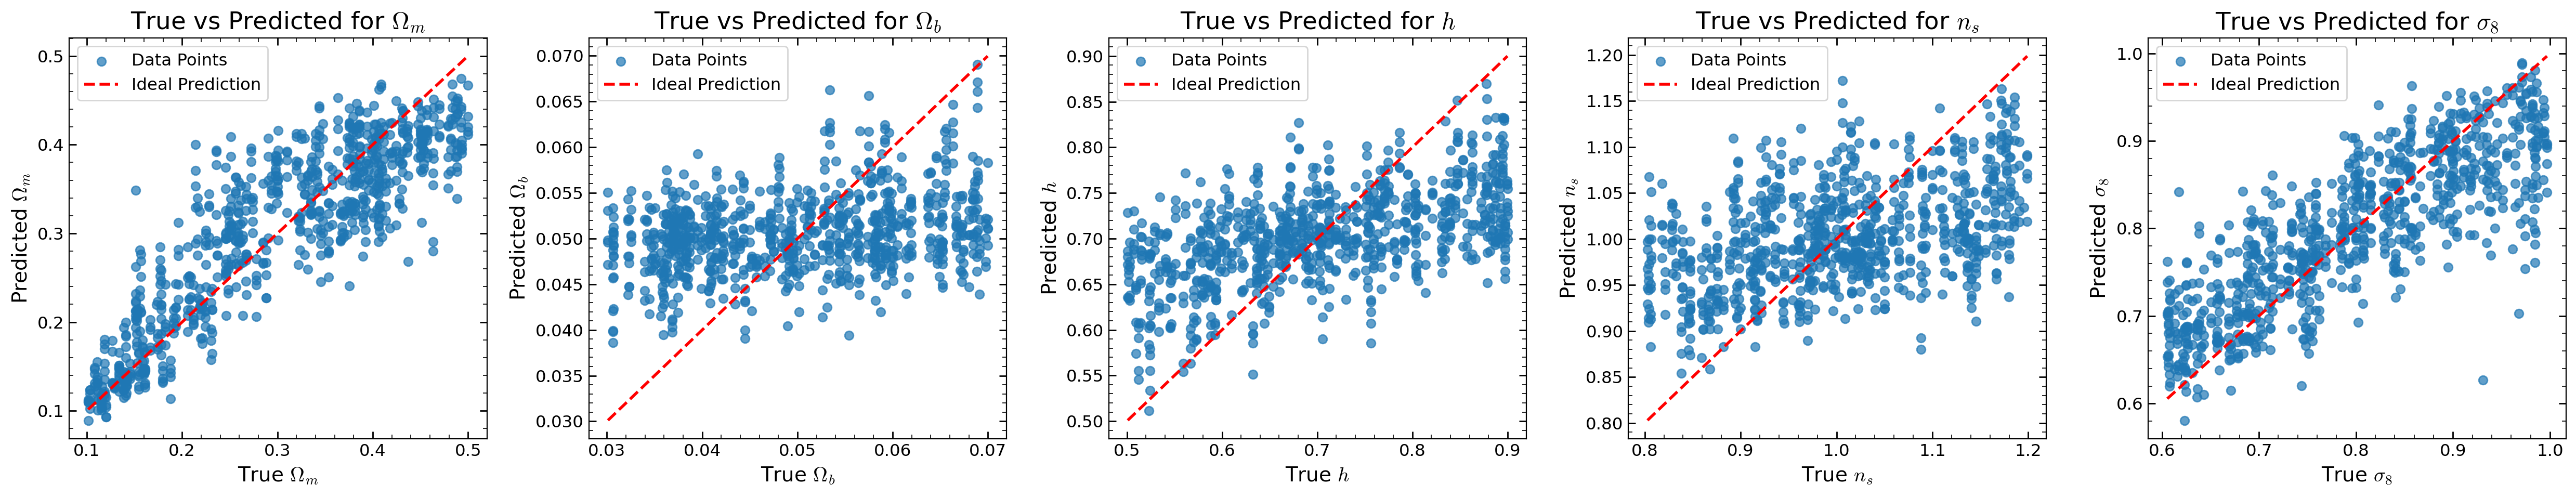

In [11]:
# Select a subset of the data for visualization
subsample = 1000
xtrain_subset = xtest[:subsample]
thetatrain_subset = thetatest[:subsample]

# Predict using the trained model
predicted_values = multi_output_model.predict(xtrain_subset)

# Calculate the global RMSE
rmse = np.sqrt(np.mean((thetatrain_subset - predicted_values) ** 2, axis=0))
for i, name in enumerate(target_names):
    print(f"RMSE {name}:       \t{rmse[i]:.4f}")

# Plot true vs predicted values for each target
num_targets = thetatrain.shape[1]
fig, axs = plt.subplots(1, num_targets, figsize=(
    5 * num_targets, 5), sharey=False)

for i, ax in enumerate(axs):
    ax.scatter(
        thetatrain_subset[:, i], predicted_values[:, i], alpha=0.7, label='Data Points'
    )
    ax.plot(
        [thetatrain_subset[:, i].min(), thetatrain_subset[:, i].max()],
        [thetatrain_subset[:, i].min(), thetatrain_subset[:, i].max()],
        'r--',
        label='Ideal Prediction'
    )
    ax.set_xlabel(f'True {target_names[i]}')
    ax.set_ylabel(f'Predicted {target_names[i]}')
    ax.legend()
    ax.set_title(f'True vs Predicted for {target_names[i]}')
plt.tight_layout()
plt.show()

Text(0.5, 0.98, 'nbar+nz+Pk0+Pk2+Pk4, mtng_lightcone')

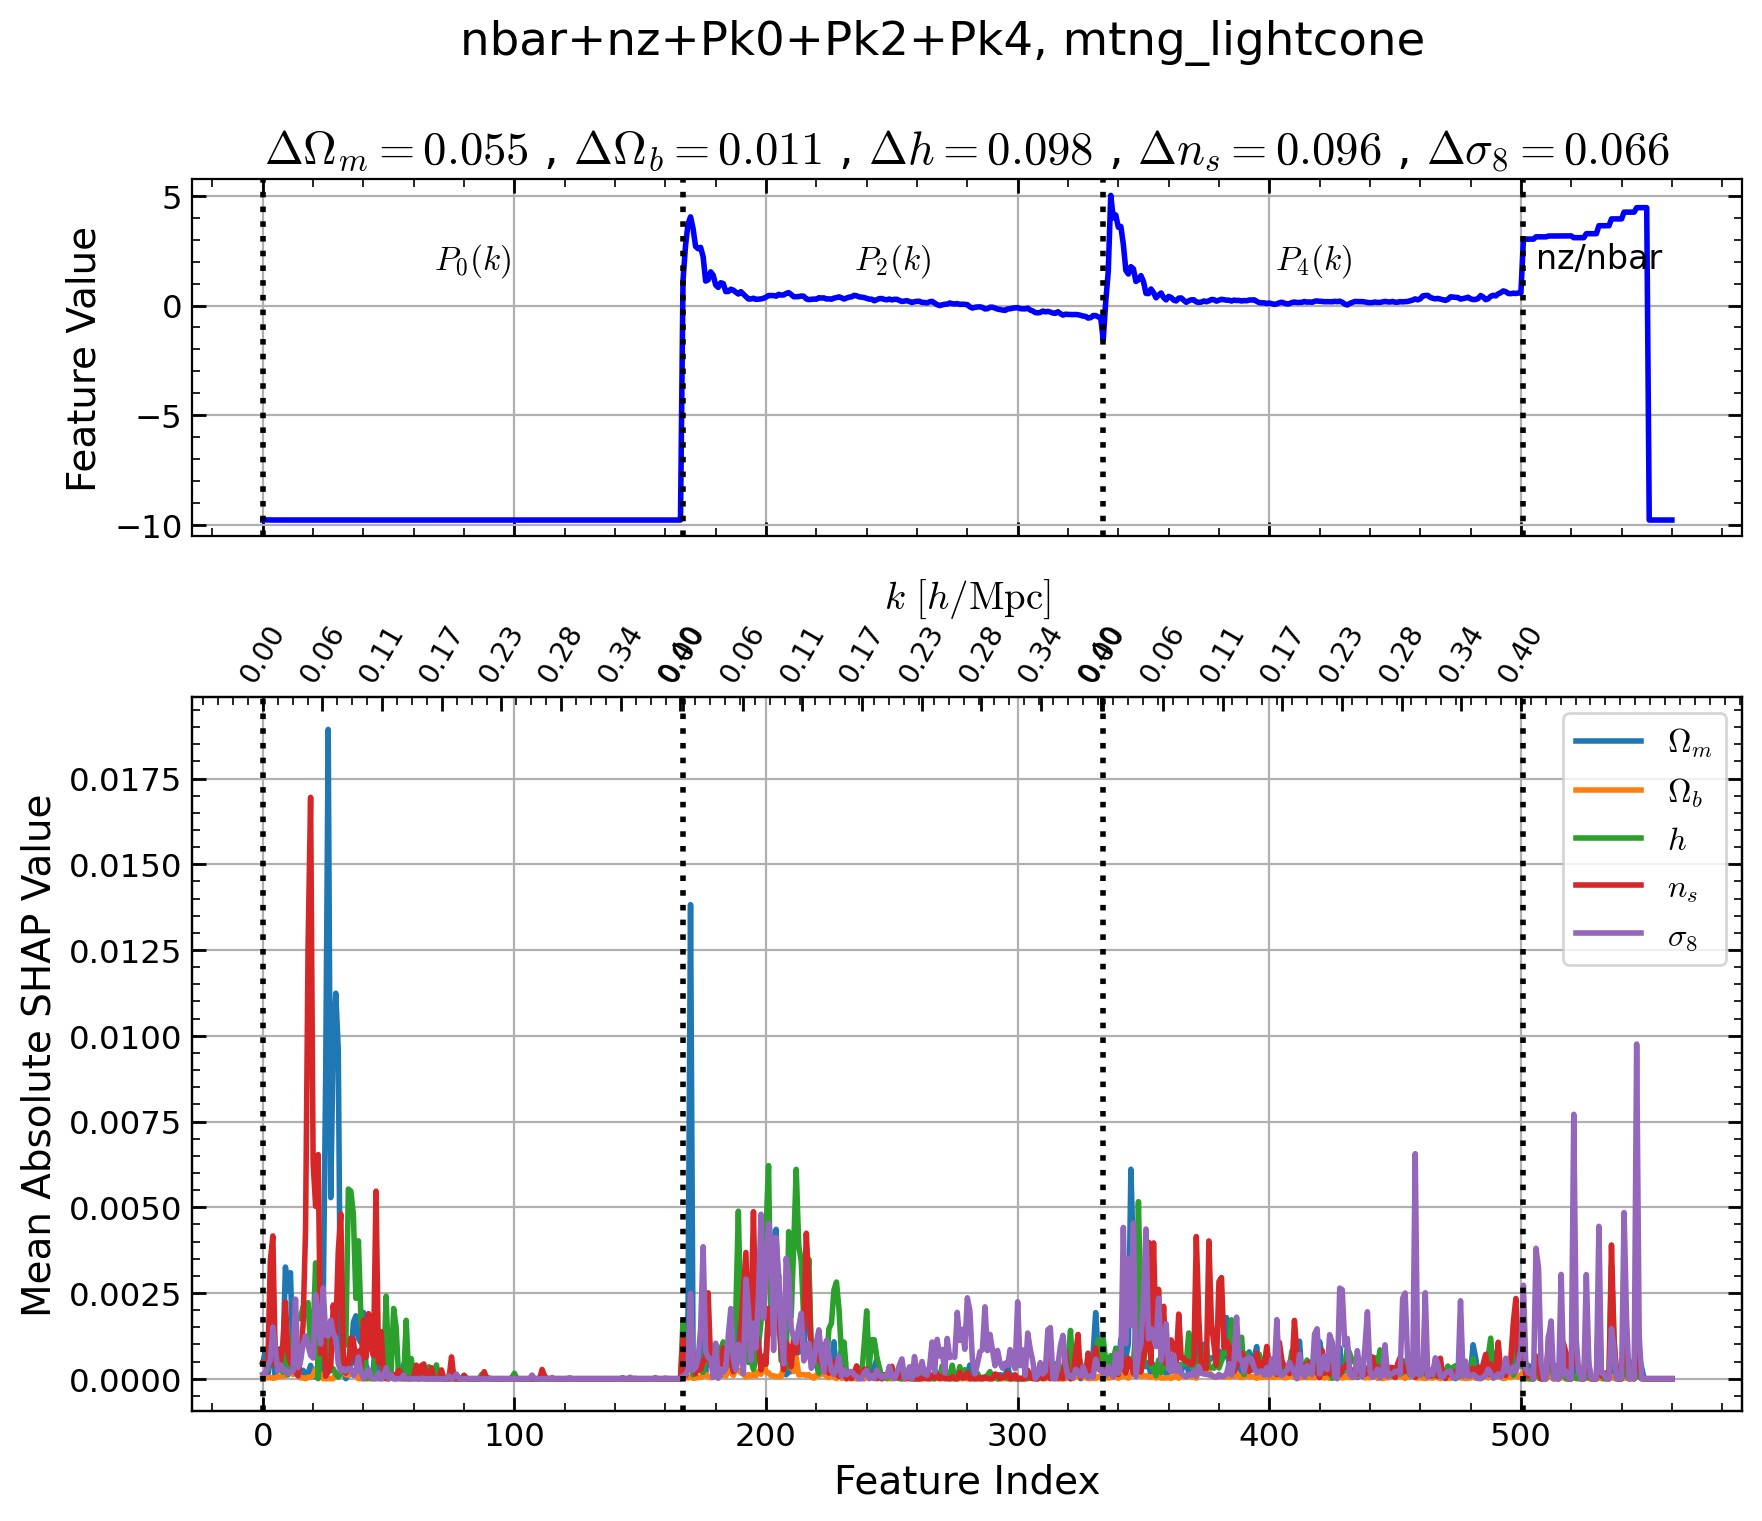

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True,
                        gridspec_kw={'height_ratios': [1, 2], 'hspace': 0.3})

# Top subplot: Data vector example
ind = 0
ax = axs[0]
ax.plot(range(xtest.shape[1]), xtest[ind],
        label=f'Data Vector Example {ind}', color='blue')
ax.set_ylabel('Feature Value')
ax.grid()
ax.set_title(' , '.join([f'$\Delta {target_names[i][1:-1]} = {rmse[i]:.3f}$'
                         for i in range(len(target_names))]))

for i in range(4):
    ax.axvline(i * Nk, color='k', ls=':', lw=2)
for i in range(3):
    ax.text(i * Nk + Nk / 2, 1.7, f'$P_{{{2*i}}}(k)$',
            horizontalalignment='center', fontsize=12, color='k')
ax.text(3*Nk + 5, 1.7, r'nz/nbar',
        horizontalalignment='left', fontsize=12, color='k')

# Bottom subplot: SHAP values as a function of feature index
ax = axs[1]
for i, estimator in enumerate(multi_output_model.estimators_):
    explainer = shap.TreeExplainer(estimator)
    shap_values = explainer.shap_values(xtrain)
    mean_shap_values = np.abs(shap_values).mean(axis=0)
    ax.plot(range(len(mean_shap_values)),
            mean_shap_values, label=f'{target_names[i]}')

ax.set_xlabel('Feature Index')
ax.set_ylabel('Mean Absolute SHAP Value')
ax.legend()
ax.grid()
for i in range(4):
    ax.axvline(i * Nk, color='k', ls=':', lw=2)

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
Nticks = (Nk//20)
ax2.set_xticks(np.concatenate(
    [i*Nk + np.linspace(0, Nk - 1, Nticks) for i in range(3)]))
ticklabels = [f'{xk3D[i]:.2f}' for i in np.linspace(0, Nk-1, Nticks, dtype=int)]
ax2.set_xticklabels(3*ticklabels, rotation=60, fontsize=10)
ax2.set_xlabel(r'$k\ [h/\mathrm{Mpc}]$')

fig.suptitle(modeldir.split('/')[-2] + ', ' + modeldir.split('/')[-3])

## Check loss functions and such

Text(0.5, 1.0, 'nbar+nz+Pk0+Pk2+Pk4')

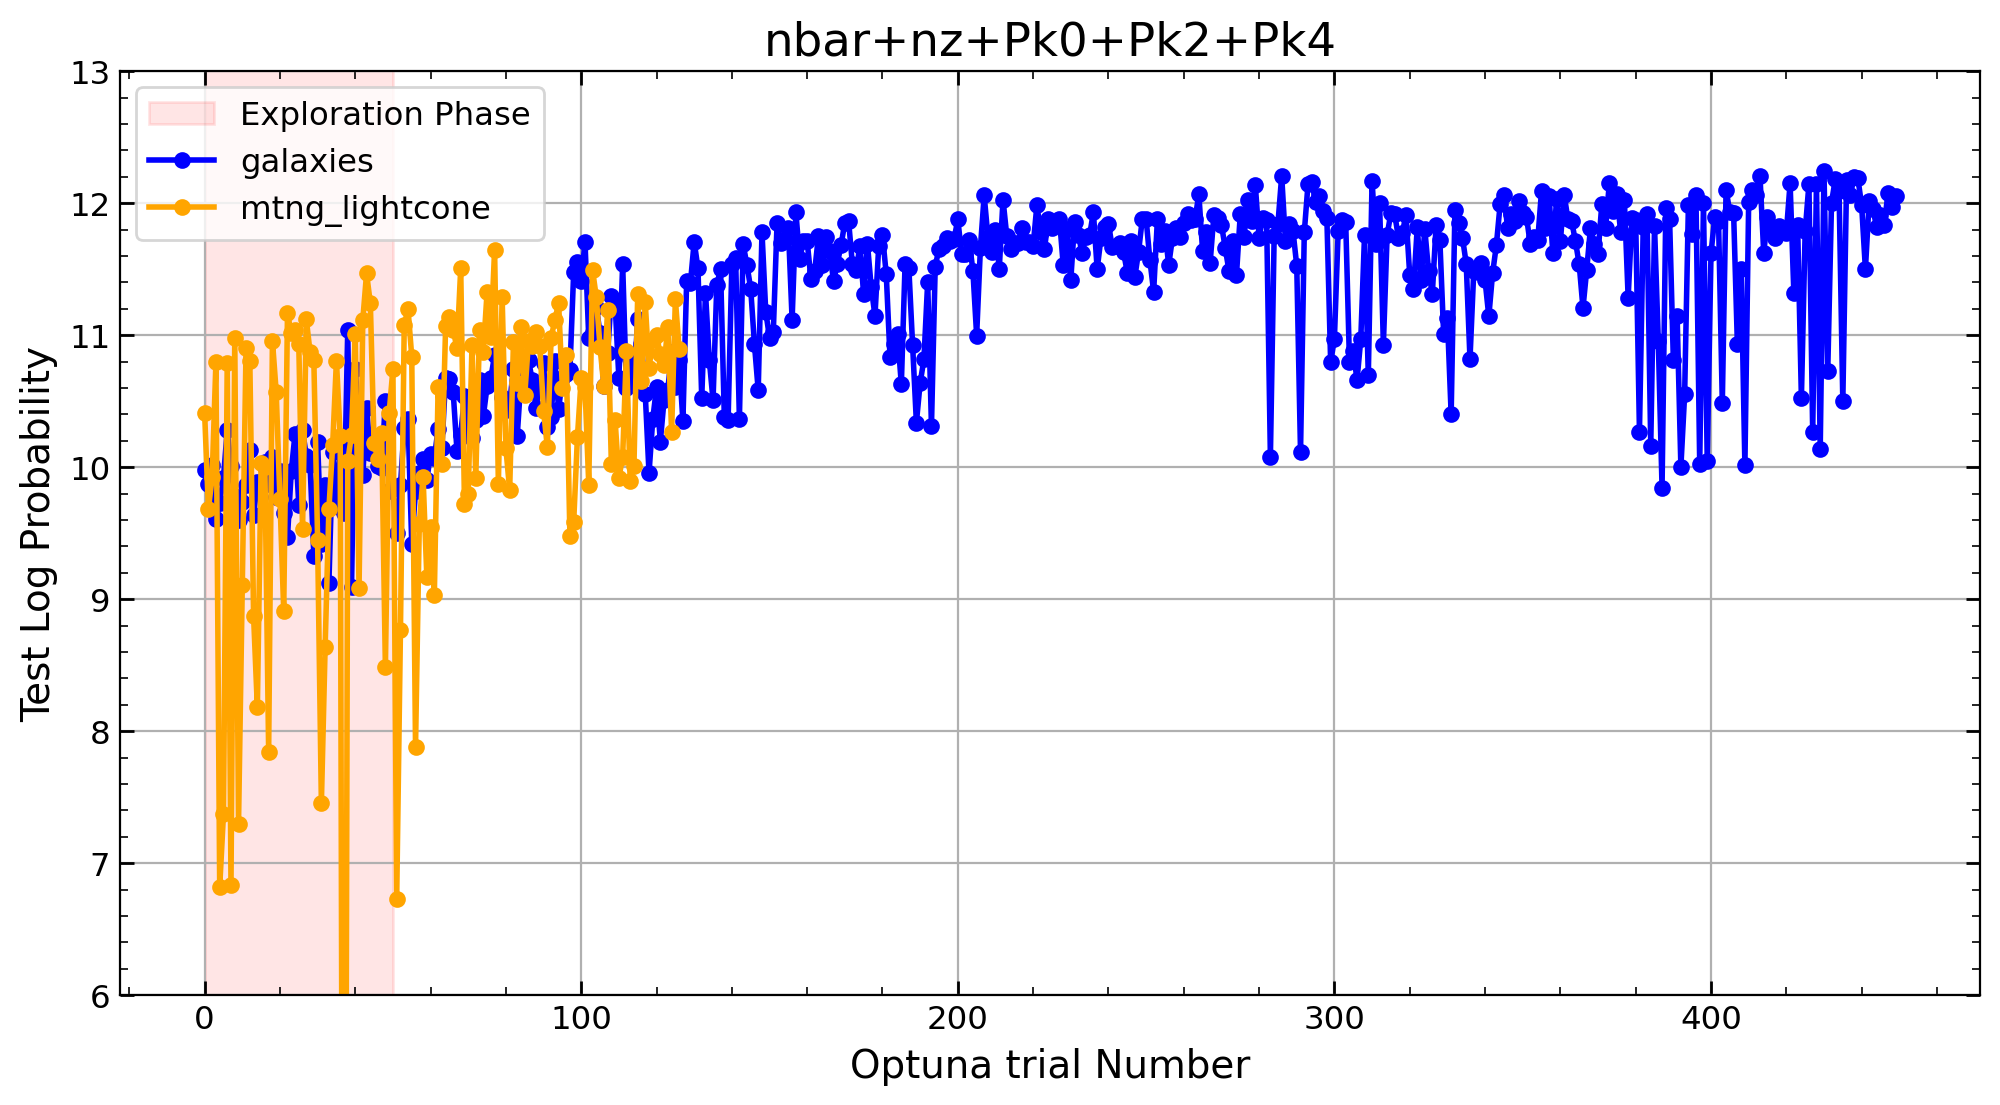

In [7]:
import optuna


def plot_study(study, ax,  **kwargs):
    # --- Data Extraction ---
    completed_trials = [t for t in study.trials if t.state ==
                        optuna.trial.TrialState.COMPLETE]
    trial_numbers = [t.number for t in completed_trials]
    log_probabilities = [t.value for t in completed_trials]
    ax.plot(trial_numbers, log_probabilities, '-o', **kwargs)


# --- Plotting ---
n_startup_trials = 50
f, ax = plt.subplots(figsize=(12, 6))
ax.fill_betweenx([0, 100], [0, 0], [n_startup_trials]*2,
                 color='r', alpha=0.1, label='Exploration Phase')
ax.set_xlabel("Optuna trial Number")
ax.set_ylabel("Test Log Probability")
ax.grid(True)
ax.set_ylim(6, 13)


modelpath = '/anvil/scratch/x-mho1/cmass-ili/abacuslike/fastpm_hodzbias/models/galaxy/nbar+zPk0+zPk2+zPk4/kmin-0.0_kmax-0.4'
studyfile = join(modelpath, 'optuna_study.db')
summary = modelpath.split('/')[-2]
study = optuna.load_study(study_name=summary, storage=f'sqlite:///{studyfile}')
plot_study(study, ax, color='blue', label='galaxies', markersize=5)

modelpath = '/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm_recnoise_rot/models/mtng_lightcone/nbar+nz+Pk0+Pk2+Pk4/kmin-0.0_kmax-0.4'
studyfile = join(modelpath, 'optuna_study.db')
summary = modelpath.split('/')[-2]
study = optuna.load_study(study_name=summary, storage=f'sqlite:///{studyfile}')
plot_study(study, ax, color='orange', label='mtng_lightcone', markersize=5)

ax.legend(loc='upper left')
ax.set_title(modelpath.split('/')[-2])

100%|██████████| 1/1 [00:00<00:00, 327.78it/s]


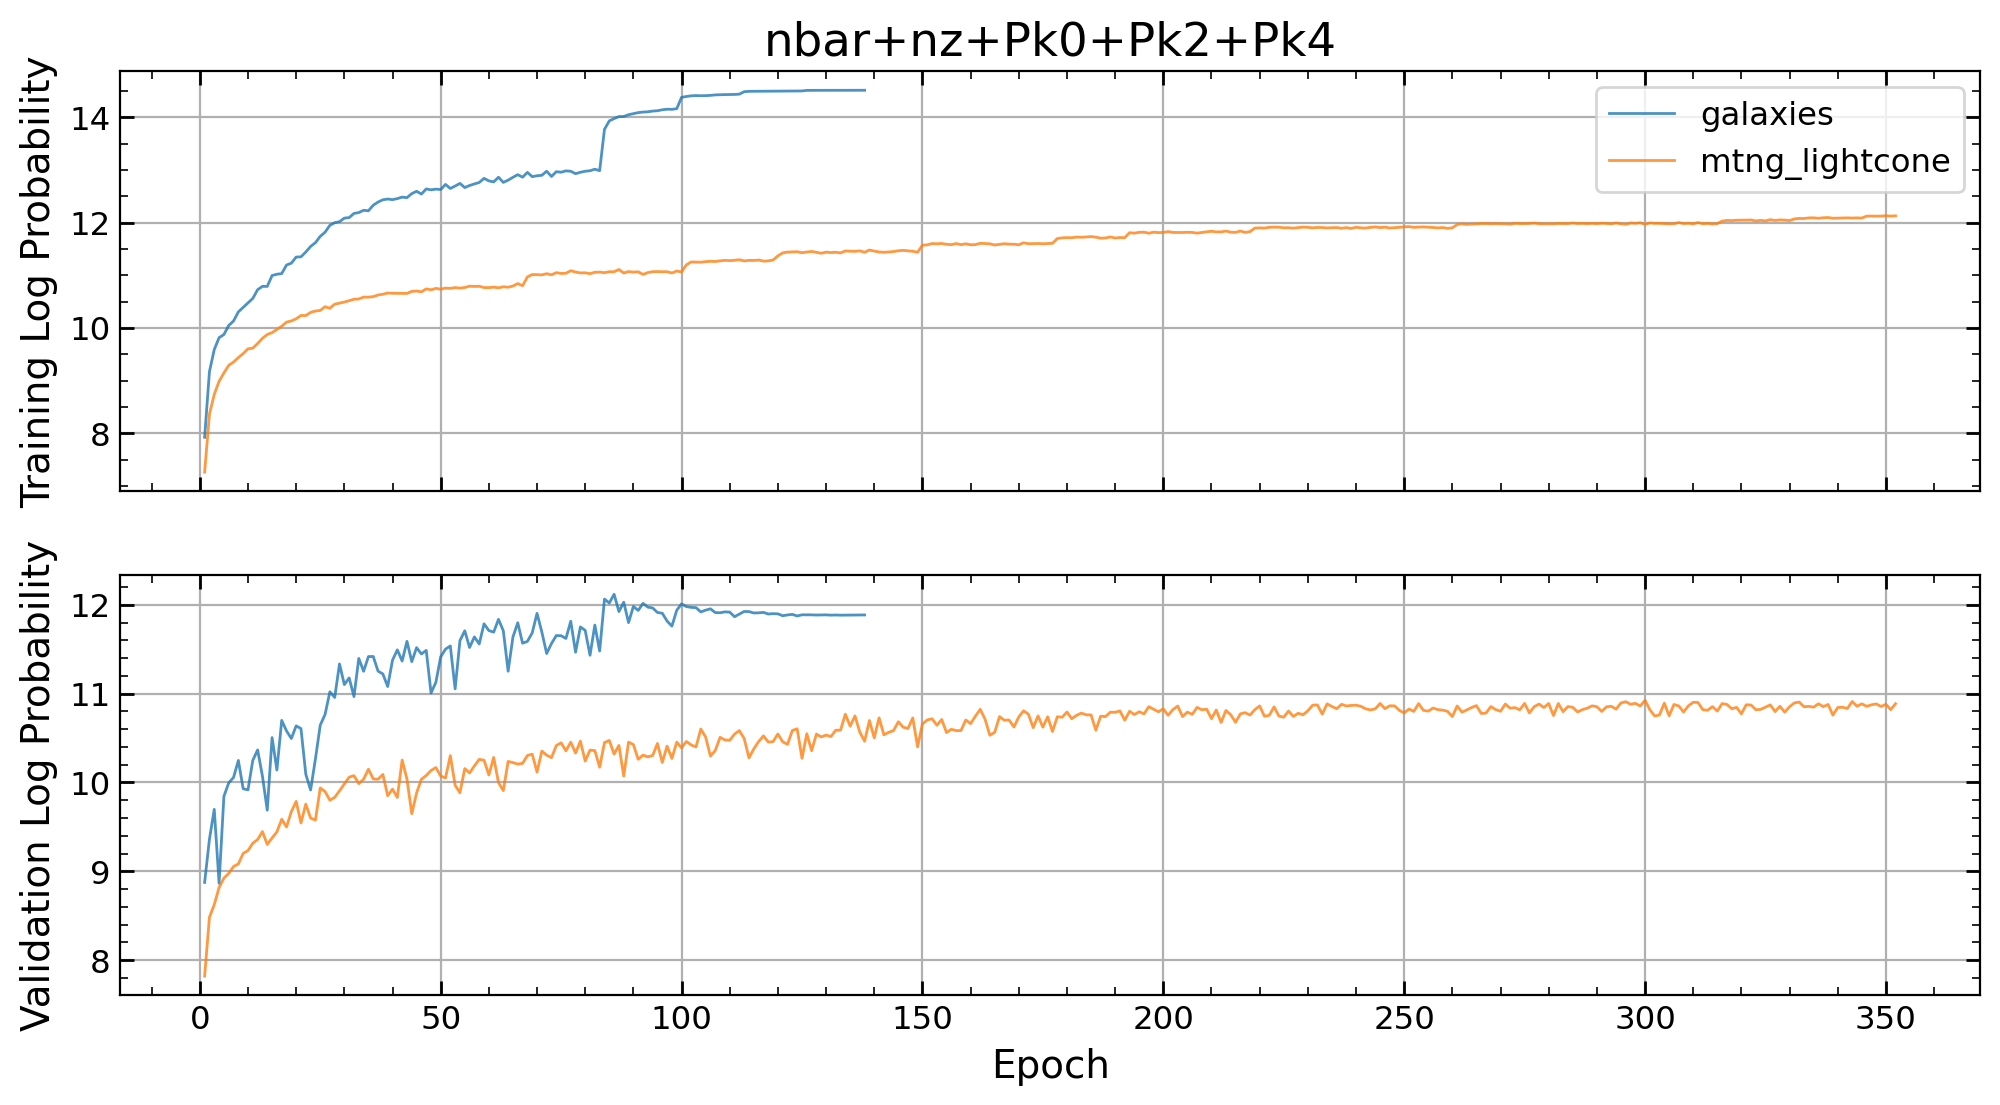

In [4]:
def plot_training_validation_logs(netpath, ss=1, axs=None, **kwargs):
    netlist = os.listdir(netpath)
    netlist.sort()
    for n in tqdm(netlist[-ss:]):
        filepath = join(netpath, n, 'summary.json')
        if not os.path.exists(filepath):
            continue
        with open(filepath, 'r') as f:
            history = json.load(f)

        x_ = range(1, len(history[0]['training_log_probs']) + 1)

        ax = axs[0]
        ax.plot(x_, history[0]['training_log_probs'], alpha=0.8, lw=1, **kwargs)

        ax = axs[1]
        ax.plot(x_, history[0]['validation_log_probs'],
                alpha=0.8, lw=1, **kwargs)

    return axs


# Example usage
f, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
axs[0].grid()
axs[1].grid()

axs[0].set(ylabel='Training Log Probability')
axs[1].set(xlabel='Epoch', ylabel='Validation Log Probability')

modelpath = '/anvil/scratch/x-mho1/cmass-ili/abacuslike/fastpm_hodzbias/models/galaxy/nbar+zPk0+zPk2+zPk4/kmin-0.0_kmax-0.4'
netpath = join(modelpath, 'nets')
axs = plot_training_validation_logs(netpath, axs=axs, label='galaxies')

modelpath = '/anvil/scratch/x-mho1/cmass-ili/abacuslike/fastpm_recnoise_1hod/models/mtng_lightcone_temp/nbar+nz+Pk0+Pk2+Pk4/kmin-0.0_kmax-0.4'
netpath = join(modelpath, 'nets')
axs = plot_training_validation_logs(netpath, axs=axs, label='mtng_lightcone')


axs[0].set_title(modelpath.split('/')[-2])
axs[0].legend()

## Test plane-parallel approximation

In [1]:
# %%
# ----- IMPORTS -----
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18
import MAS_library as MASL
import Pk_library as PKL
import redshift_space_library as RSL
from cmass.survey.tools import xyz_to_sky, sky_to_xyz

# ----- SIMULATION & SURVEY PARAMETERS -----
Lbox = 1000.0       # Box size in Mpc/h
grid = 128          # Grid resolution for Pk measurement
n_gal = 1e-4        # Galaxy number density in (h/Mpc)^3
z_ref = 0.5         # Effective redshift of the box
zmin, zmax = 0., 1  # Redshift range for sky-cut
mas = 'TSC'         # Mass-assignment scheme ('TSC', 'CIC', etc.)
cosmo = Planck18    # Cosmology

In [7]:
# %%
def calculate_pk(pos, L, N, current_mas, axis=2):
    """Computes the 3D power spectrum multipoles from positions."""
    delta = np.zeros((N, N, N), dtype=np.float32)
    MASL.MA(pos.astype(np.float32), delta, BoxSize=L, MAS=current_mas)
    delta /= np.mean(delta)
    delta -= 1.0
    pk = PKL.Pk(delta, L, axis=2, MAS=current_mas, threads=4)
    return pk.k3D, pk.Pk


def apply_rsd_pp(pos, vel, L, cosmo, z, axis=2):
    """Applies RSD using the plane-parallel approximation."""
    pos_rsd = pos.copy().astype(np.float32)
    vel = vel.astype(np.float32)
    hubble_z = cosmo.H(z).value / cosmo.h
    RSL.pos_redshift_space(pos_rsd, vel, L, hubble_z, z, axis=axis)
    pos_rsd %= L
    return pos_rsd


def mask_z(pos, cosmo, zmin, zmax):
    """Masks positions based on redshift range."""
    rdz = xyz_to_sky(pos, None, cosmo)
    mask = (rdz[:, 2] >= zmin) & (rdz[:, 2] <= zmax)
    return pos[mask], rdz[mask]


def apply_rsd_sky(pos, vel, current_cosmo):
    """Applies RSD from a central observer and performs a sky-cut."""
    rdz = xyz_to_sky(pos, vel, current_cosmo)
    xyz = sky_to_xyz(rdz, current_cosmo)
    return xyz

In [16]:
# %%
# --- Generate Base Galaxy Catalog ---
# Ngal = int(n_gal * Lbox**3)
import h5py
from scipy.spatial.transform import Rotation as R
lhid = 663
filename = f'/anvil/scratch/x-mho1/cmass-ili/quijote/nbody/L1000-N128/{lhid}/galaxies/hod{lhid:04}1.h5'
with h5py.File(filename, 'r') as f:
    if 'pos' not in f:
        a = list(f.keys())[0]
        f = f[a]
    pos = f['pos'][:]
    vel = f['vel'][:]
# pos = Lbox * np.random.rand(Ngal, 3)
# vel = np.random.normal(loc=0.0, scale=300.0, size=(Ngal, 3))  # km/s
print(pos.shape, vel.shape)

# --- Compute Power Spectra for Different RSD Models ---
pk_results = {}

# Model 1: Plane-Parallel RSD
pos_pp = apply_rsd_pp(pos, vel, Lbox, cosmo, z_ref)
delta_pp = pos_pp - pos
# pos_pp, rdz_pp = mask_z(pos_pp, cosmo, zmin, zmax)
k, pk_data = calculate_pk(pos_pp, Lbox, grid, mas)
pk_results['Plane-Parallel'] = (k, pk_data)

# Model 2: Full-Sky RSD
pos_fs = apply_rsd_sky(pos, vel, cosmo)
delta_fs = pos_fs - pos
# pos_fs, rdz_fs = mask_z(pos_fs, cosmo, zmin, zmax)
k, pk_data = calculate_pk(pos_fs, Lbox, grid, mas)
pk_results['Full-Sky'] = (k, pk_data)

# --- Rotate pos_fs to align (1, 1, 1) with the z-axis ---
# Define the target vector and the z-axis
target_vector = np.array([1, 1, 1])
z_axis = np.array([0, 0, 1])

# Normalize the vectors
target_vector = target_vector / np.linalg.norm(target_vector)
z_axis = z_axis / np.linalg.norm(z_axis)

# Compute the rotation matrix using scipy
rotation_vector = np.cross(target_vector, z_axis)
rotation_angle = np.arccos(np.dot(target_vector, z_axis))
rotation = R.from_rotvec(
    rotation_angle * rotation_vector / np.linalg.norm(rotation_vector))
rotation_matrix = rotation.as_matrix()

# Apply the rotation to pos_fs
pos_rot = np.dot(pos_fs, rotation_matrix.T)
pos_rot[:, [0, 1]] += Lbox
k, pk_data = calculate_pk(pos_rot, 2*Lbox, 2*grid, mas)
pk_results['Rotated Full-Sky'] = (k, pk_data)

print("Calculation complete. Results are in the 'pk_results' dictionary.")

(180134, 3) (180134, 3)

Computing power spectrum of the field...
Time to complete loop = 0.12
Time taken = 0.15 seconds

Computing power spectrum of the field...
Time to complete loop = 0.12
Time taken = 0.14 seconds

Computing power spectrum of the field...
Time to complete loop = 0.99
Time taken = 1.08 seconds
Calculation complete. Results are in the 'pk_results' dictionary.


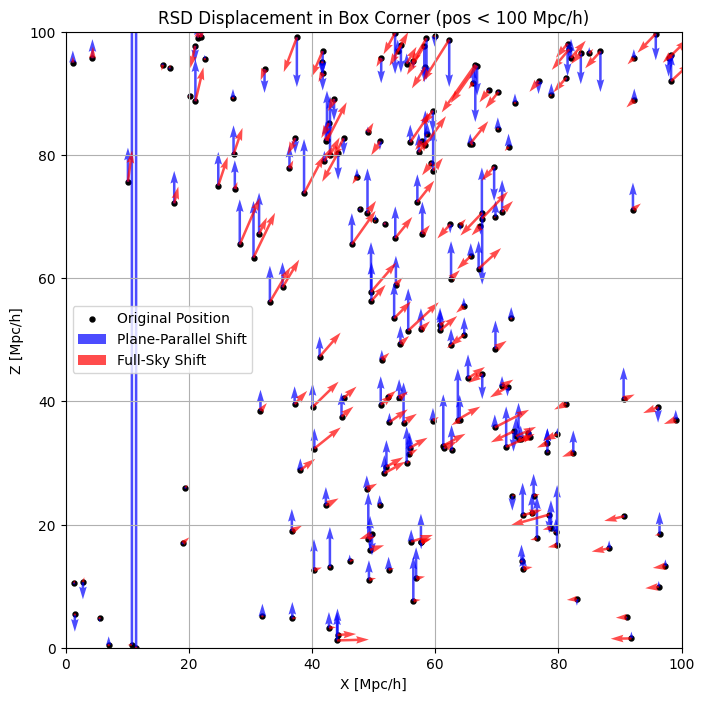

In [17]:
# %%
# --- Plotting Routine for the Box Corner ---

# 1. Create a boolean mask for points in the corner of the box
mask = np.all(pos < 100, axis=1)

# Apply this mask to the position and displacement arrays
pos_corner = pos[mask]
delta_pp_corner = delta_pp[mask]
delta_fs_corner = delta_fs[mask]

# Create a single plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect('equal')

# 2. Plot the original positions in the corner as reference points
ax.scatter(pos_corner[:, 0], pos_corner[:, 2],
           s=50, c='black', marker='.', label='Original Position')

# 3. Plot displacement vectors for Plane-Parallel RSD (blue arrows)
ax.quiver(pos_corner[:, 0], pos_corner[:, 2],
          delta_pp_corner[:, 0], delta_pp_corner[:, 2],
          angles='xy', scale_units='xy', scale=1,
          color='b', alpha=0.7, label='Plane-Parallel Shift')

# 4. Plot displacement vectors for Full-Sky RSD (red arrows)
ax.quiver(pos_corner[:, 0], pos_corner[:, 2],
          delta_fs_corner[:, 0], delta_fs_corner[:, 2],
          angles='xy', scale_units='xy', scale=1,
          color='r', alpha=0.7, label='Full-Sky Shift')

# 5. Adjust plot limits to focus on the corner
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)

# Set plot labels, title, and legend
ax.set_title('RSD Displacement in Box Corner (pos < 100 Mpc/h)')
ax.set_xlabel('X [Mpc/h]')
ax.set_ylabel('Z [Mpc/h]')
ax.legend()
ax.grid()

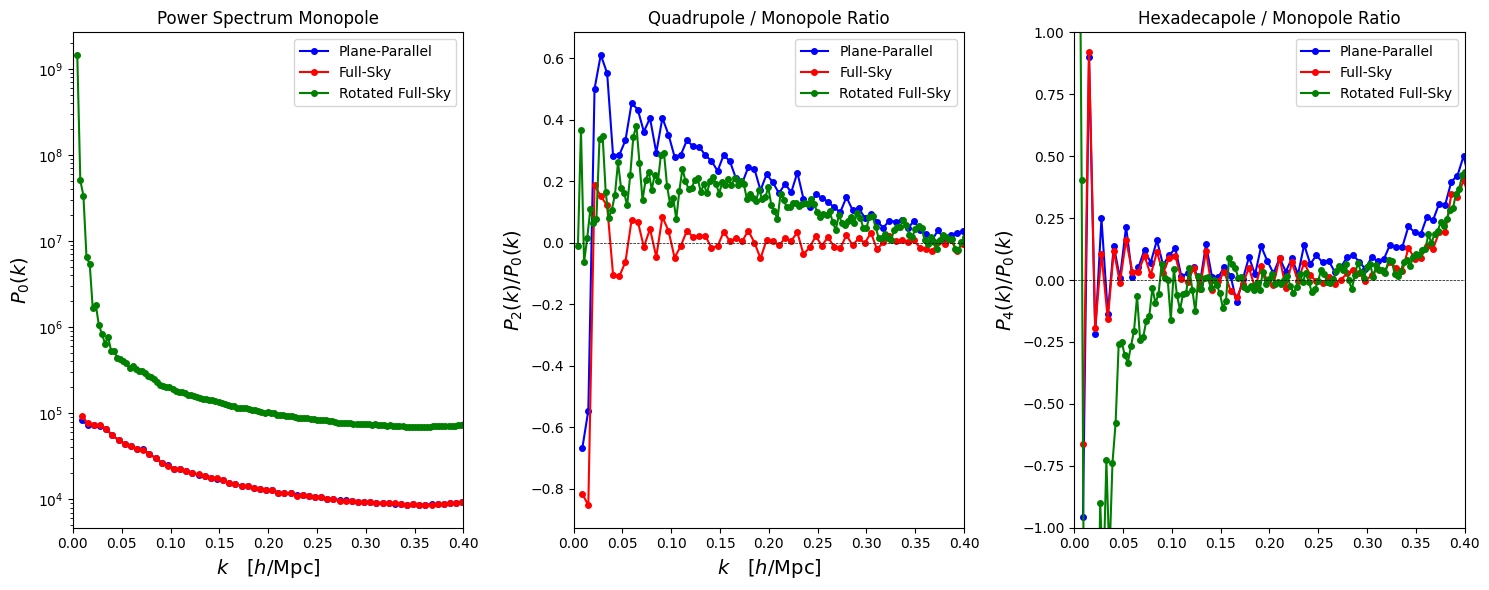

In [21]:
# %%
# --- Plot the P(k) Results ---

# Define colors to match the previous quiver plots
colors = {
    'Plane-Parallel': 'blue',
    'Full-Sky': 'red',
    'Rotated Full-Sky': 'green'
}

fig, axs = plt.subplots(1, 3, figsize=(15, 6), tight_layout=True)

# Loop through the results and plot with specific colors
for name, (k, pk_data) in pk_results.items():
    monopole = pk_data[:, 0]
    quadrupole = pk_data[:, 1]
    hexadecapole = pk_data[:, 2]
    color = colors[name]

    # Plot Monopole
    axs[0].plot(k, monopole, label=name, marker='o', linestyle='-',
                markersize=4, color=color)

    # Plot Quadrupole / Monopole
    axs[1].plot(k, quadrupole / monopole, label=name, marker='o',
                linestyle='-', markersize=4, color=color)

    # Plot Hexadecapole / Monopole
    axs[2].plot(k, hexadecapole / monopole, label=name, marker='o',
                linestyle='-', markersize=4, color=color)

# --- Formatting ---
# Format Monopole plot
axs[0].semilogy()
axs[0].set_xlabel(r'$k \quad [h/\mathrm{Mpc}]$', fontsize=14)
axs[0].set_ylabel(r'$P_0(k)$', fontsize=14)
axs[0].set_title('Power Spectrum Monopole')
axs[0].set_xlim(0, 0.4)
axs[0].legend()

# Format Ratio plot
axs[1].axhline(0, color='k', lw=0.5, ls='--')
axs[1].set_xlabel(r'$k \quad [h/\mathrm{Mpc}]$', fontsize=14)
axs[1].set_ylabel(r'$P_2(k) / P_0(k)$', fontsize=14)
axs[1].set_title('Quadrupole / Monopole Ratio')
axs[1].set_xlim(0, 0.4)
axs[2].set_ylim(-1, 1)
axs[1].legend()

# Format Hexadecapole plot
axs[2].axhline(0, color='k', lw=0.5, ls='--')
axs[1].set_xlabel(r'$k \quad [h/\mathrm{Mpc}]$', fontsize=14)
axs[2].set_ylabel(r'$P_4(k) / P_0(k)$', fontsize=14)
axs[2].set_title('Hexadecapole / Monopole Ratio')
axs[2].set_xlim(0, 0.4)
axs[2].set_ylim(-1, 1)
axs[2].legend()


plt.show()

In [17]:
from scipy.spatial.transform import Rotation as R

L = 2000
pos = np.array([[0, 0, 0],
                [L, 0, 0],
                [0, L, 0],
                [0, 0, L],
                [L, L, 0],
                [L, 0, L],
                [0, L, L],
                [L, L, L]])
# Define the target vector (1, 1, 1) and the x-axis
target_vector = np.array([1, 1, 1])
x_axis = np.array([1, 0, 0])

# Normalize the vectors
# target_vector = target_vector / np.linalg.norm(target_vector)
# x_axis = x_axis / np.linalg.norm(x_axis)

# Compute the rotation matrix using R.align_vectors
rotation, _ = R.align_vectors([x_axis], [target_vector])
pos = rotation.apply(pos)

pos += [100, L, L]
print(pos.min(axis=0))
print(pos.max(axis=0))

[100.         422.64973081 422.64973081]
[3564.10161514 3577.35026919 3577.35026919]
